## Прогноз получения работы студентом

**Задача:** классифицировать, получит ли студент рабочее место. Выявить самые эффективные способы получение работы для студентов.

### Данные
- Анкеты студентов: оценки, опыт стажировок, курсы, участие в проектах и др.
- Целевая переменная: факт получения работы (0/1).

### Модель
- Основные алгоритмы: линейные модели + деревья.
- Метрики: Accuracy, F1-score, ROC-AUC.

План:
- поработать с данными, убрать дисбаланс и другие проблемы
- предобработка под лог рег, обучение лог рег
- исключаем бесполезные признаки
- делаем рассчёт эффективности (количество усилий/количество результата)
- кластаризируем датасет
- находим лучшую стратегию и формулируем их принцип


### Результат
- Определены наиболее информативные признаки.
- Построена финальная модель с оптимальным балансом точности и простоты.
- Сформирована стратегия по улучшению шансов трудоустройства на основе кластеров.

### Дальнейшие шаги
- Добавление новых признаков (например, данные о стажировках, soft-skills).


In [ ]:
import pandas as pd

df = pd.read_csv("/kaggle/input/engineering-placements-prediction/collegePlace.csv")
df.shape

(2966, 8)

In [ ]:
df.columns

Index(['Age', 'Gender', 'Stream', 'Internships', 'CGPA', 'Hostel',
       'HistoryOfBacklogs', 'PlacedOrNot'],
      dtype='object')

In [ ]:
target_name = 'PlacedOrNot'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import entropy


In [ ]:
df[target_name].value_counts()

PlacedOrNot
1    1639
0    1327
Name: count, dtype: int64

# EDA

In [ ]:
import os
import base64
from io import BytesIO
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
from IPython.display import display, Markdown
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=FutureWarning)

def bold(text): return f"**{text}**"
def code(text): return f"`{text}`"

# Объединённая и дополненная версия функции с сохранением графиков и расширенным анализом
def analyze_and_export(df: pd.DataFrame, target_column: str, output_dir: str = "report_output"):
    os.makedirs(output_dir, exist_ok=True)
    report_lines = []

    def fig_to_base64_img_tag():
        buf = BytesIO()
        plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
        plt.close()
        buf.seek(0)
        img_base64 = base64.b64encode(buf.read()).decode('utf-8')
        return f"<img src='data:image/png;base64,{img_base64}' width='800'>"

    report_lines.append("<h1>📊 Анализ набора данных</h1>")





    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_column in categorical_cols:
        categorical_cols.remove(target_column)
    if target_column in numerical_cols:
        numerical_cols.remove(target_column)

        # 📋 Табличные характеристики признаков
    report_lines.append("<h3>📋 Табличные характеристики признаков</h3>")
    # desc_df = pd.DataFrame({
    #     "Уникальных значений": df.nunique(),
    #     "Тип данных": df.dtypes,
    #     "Минимум": df[numerical_cols].min(),
    #     "Максимум": df[numerical_cols].max(),
    #     "Среднее": df[numerical_cols].mean(),
    #     "Ст. отклонение": df[numerical_cols].std()
    # }).fillna("-")
    # report_lines.append(desc_df.to_html())

    # report_lines.append(f"<h3>Категориальные признаки:</h3><p>{', '.join(categorical_cols) or 'нет'}</p>")
    # report_lines.append(f"<h3>Числовые признаки:</h3><p>{', '.join(numerical_cols) or 'нет'}</p>")

    # Пропущенные значения
    missing = df.isnull().sum()[df.isnull().sum() > 0]
    report_lines.append("<h3>🔍 Пропущенные значения</h3>")
    if not missing.empty:
        report_lines.append(missing.to_frame("Количество пропусков").to_html())
    else:
        report_lines.append("<p>Нет пропущенных значений.</p>")

    kl_values = []
    for col in df.columns:
        if col == target_column:
            kl_values.append("-")
            continue

        col_values = df[col].dropna()
        if df[col].dtype == 'object' or df[col].nunique() < 20:
            dist = col_values.value_counts(normalize=True)
        else:
            dist, _ = np.histogram(col_values, bins=10, density=True)
            dist = dist / np.sum(dist)

        uniform = np.full_like(dist, 1 / len(dist))
        try:
            kl = entropy(dist, uniform)
            kl_values.append(round(kl, 4))
        except:
            kl_values.append("error")

    desc_df = pd.DataFrame({
        "Уникальных значений": df.nunique(),
        "Тип данных": df.dtypes,
        "Минимум": df.select_dtypes(include=[np.number]).min(),
        "Максимум": df.select_dtypes(include=[np.number]).max(),
        "Среднее": df.select_dtypes(include=[np.number]).mean(),
        "Ст. отклонение": df.select_dtypes(include=[np.number]).std(),
        "KL-дивергенция": kl_values
    }).fillna("-")

    report_lines.append(desc_df.to_html())
    # Распределение категориальных признаков
    report_lines.append("<h3>📋 Распределение категориальных признаков</h3>")
    small_cat_cols = [col for col in categorical_cols if df[col].nunique() <= 4]
    large_cat_cols = [col for col in categorical_cols if df[col].nunique() > 4]

    for col in large_cat_cols:
        plt.figure(figsize=(12, 4))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.title(f'Распределение: {col}')
        report_lines.append(f"<h4>{col}</h4>")
        report_lines.append(fig_to_base64_img_tag())

    for i in range(0, len(small_cat_cols), 2):
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        col1 = small_cat_cols[i]
        sns.countplot(data=df, x=col1, order=df[col1].value_counts().index, ax=axes[0])
        axes[0].set_title(f'Распределение: {col1}')
        if i + 1 < len(small_cat_cols):
            col2 = small_cat_cols[i + 1]
            sns.countplot(data=df, x=col2, order=df[col2].value_counts().index, ax=axes[1])
            axes[1].set_title(f'Распределение: {col2}')
        else:
            axes[1].axis('off')
        report_lines.append(fig_to_base64_img_tag())

    # Распределение числовых признаков
    report_lines.append("<h3>📈 Распределение числовых признаков</h3>")
    num_pairs = [(numerical_cols[i], numerical_cols[i + 1] if i + 1 < len(numerical_cols) else None)
                 for i in range(0, len(numerical_cols), 2)]
    for col1, col2 in num_pairs:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        if df[col1].dropna().nunique() < 20 and pd.api.types.is_integer_dtype(df[col1]):
            sns.countplot(x=col1, data=df, ax=axes[0])
        else:
            sns.histplot(df[col1].dropna(), kde=True, ax=axes[0])
        axes[0].set_title(f'Распределение: {col1}')

        if col2:
            if df[col2].dropna().nunique() < 20 and pd.api.types.is_integer_dtype(df[col2]):
                sns.countplot(x=col2, data=df, ax=axes[1])
            else:
                sns.histplot(df[col2].dropna(), kde=True, ax=axes[1])
            axes[1].set_title(f'Распределение: {col2}')
        else:
            axes[1].axis('off')

        report_lines.append(fig_to_base64_img_tag())


    # 📊 Матрица корреляции
    report_lines.append("<h3>📊 Матрица корреляции числовых признаков</h3>")
    plt.figure(figsize=(10, 8))
    corr = df[numerical_cols + [target_column]].corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    report_lines.append(fig_to_base64_img_tag())

    # 📐 KL-дивергенция
    report_lines.append("<h3>📐 KL-дивергенция таргета</h3>")
    target_counts = df[target_column].value_counts(normalize=True)
    uniform = np.full_like(target_counts.values, 1 / len(target_counts))
    kl_div = entropy(target_counts.values, uniform)
    if kl_div < 0.05:
        severity = "❎ Отсутствие дисбаланса"
    elif kl_div < 0.3:
        severity = "⚠️ Средний дисбаланс"
    elif kl_div < 0.7:
        severity = "🚨 Большой дисбаланс"
    else:
        severity = "⛔ Критический дисбаланс"

    report_lines.append(f"<p><b>Значение:</b> {kl_div:.4f}<br><b>Оценка:</b> {severity}</p>")

    # Сохранение HTML
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    report_path = os.path.join(output_dir, f"full_report_{timestamp}.html")
    with open(report_path, "w", encoding="utf-8") as f:
        f.write("<html><head><meta charset='UTF-8'></head><body>" + "\n".join(report_lines) + "</body></html>")

    return report_path



analyze_and_export(df, target_name, "report_output")

'report_output/full_report_20250629_130254.html'

## ТАБЛИЦА: проблемные колокник и что с ними делать

| **Колонка**          | **Тип**          | **Что делать**                              |
|----------------------|------------------|----------------------------------------------|
| `Internships`        | категориальный   | из вида 0,1,2... привести к виду 0,1,2 (где 2 имеет смысл от 2 и более) |



### Для линейных моделей отдельно адаптивное логарифмирование и адаптивное маштабирование для численных и one-hot encoding.


In [ ]:
df['Internships'] = df['Internships'].apply(lambda x: min(x, 2))

# Предобработка

## Обработка под линейную модель

## Логарифмирование (при большом размахе) + маштабирование (адаптивное)

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, RobustScaler



def analyze_scaling_needs(df: pd.DataFrame) -> pd.DataFrame:

    results = []

    for col in df.columns:


        if not pd.api.types.is_numeric_dtype(df[col]):
            continue

        x = df[col].dropna()
        if len(x) < 10:
            continue

        median = np.median(x)
        mad = np.median(np.abs(x - median))
        safe_median = np.abs(median) + 1e-8
        rcv = mad / safe_median
        skewness = skew(x)
        score = rcv + 0.2 * abs(skewness)

        # Проверка на размах
        spread = x.quantile(0.95) - x.quantile(0.05)
        log_required = spread > 100

        if score < 0.1:
            recommendation = '-'
        elif score < 0.5:
            recommendation = 'StandardScaler'
        else:
            recommendation = 'RobustScaler'

        if log_required:
            recommendation = f'log+{recommendation}'

        results.append({
            'column': col,
            'RCV (mad/median)': round(rcv, 4),
            'Skewness': round(skewness, 4),
            'Spread_95%': round(spread, 2),
            'Score': round(score, 4),
            'Recommendation': recommendation
        })

    return pd.DataFrame(results).sort_values(by='Score', ascending=False).reset_index(drop=True)



def apply_custom_scaling(df: pd.DataFrame, scaling_report: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    std_cols = []
    robust_cols = []
    log_cols = []

    for _, row in scaling_report.iterrows():
        col = row['column']
        rec = row['Recommendation']

        if rec.startswith('log+'):
            log_cols.append(col)
            rec = rec.replace('log+', '')

        if rec == 'StandardScaler':
            std_cols.append(col)
        elif rec == 'RobustScaler':
            robust_cols.append(col)

    # Логарифмирование
    for col in log_cols:
        df[col] = np.sign(df[col]) * np.log1p(np.abs(df[col]))

    # Масштабирование
    if std_cols:
        scaler_std = StandardScaler()
        df[std_cols] = scaler_std.fit_transform(df[std_cols])

    if robust_cols:
        scaler_robust = RobustScaler()
        df[robust_cols] = scaler_robust.fit_transform(df[robust_cols])

    return df

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df[target_name])

In [ ]:
scaling_report = analyze_scaling_needs(train)

In [ ]:
train = apply_custom_scaling(train, scaling_report)
test = apply_custom_scaling(train, scaling_report)

In [ ]:
X_train = train.drop(target_name, axis=1)
y_train = train[target_name]

X_test = test.drop(target_name, axis=1)
y_test = test[target_name]

## Encoding

In [ ]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

In [ ]:
X_train.columns

Index(['Age', 'Internships', 'CGPA', 'Hostel', 'HistoryOfBacklogs',
       'Gender_Male', 'Stream_Computer Science', 'Stream_Electrical',
       'Stream_Electronics And Communication', 'Stream_Information Technology',
       'Stream_Mechanical'],
      dtype='object')

## LogReg

In [ ]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

def objective(trial):
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet", "none"])
    solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear", "saga"])

    valid_combinations = {
        "l1": ["liblinear", "saga"],
        "l2": ["lbfgs", "liblinear", "saga"],
        "elasticnet": ["saga"],
        "none": ["lbfgs", "saga"]
    }
    if solver not in valid_combinations[penalty]:
        raise optuna.exceptions.TrialPruned()

    C = trial.suggest_float("C", 1e-4, 1e2, log=True)
    l1_ratio = None
    if penalty == "elasticnet":
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    model = LogisticRegression(
        penalty=penalty,
        solver=solver,
        C=C,
        l1_ratio=l1_ratio,
        max_iter=1000,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]  # вероятности класса 1
    score = roc_auc_score(y_test, y_proba)
    return score

In [ ]:
# import multiprocessing
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=50, n_jobs=multiprocessing.cpu_count())  # n_jobs=4 → параллельные процессы

In [ ]:
# print("Best score:", study.best_value)
# print("Best params:", study.best_params)

In [ ]:
# The result
best_params = {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.0043597030104165916}

In [ ]:
if best_params['penalty'] != 'elasticnet':
    best_params.pop('l1_ratio', None)

model = LogisticRegression(**best_params)
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_test)[:, 1]  # вероятности класса 1
score = roc_auc_score(y_test, y_proba)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [ ]:
coefs = model.coef_[0]  # если бинарная классификация
feature_importance_linear = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient_lin': coefs,
    'abs_coef_lin': np.abs(coefs)
}).sort_values(by='abs_coef_lin', ascending=False)

In [ ]:
feature_importance_linear

,feature,coefficient_lin,abs_coef_lin
2,CGPA,1.832863,1.832863
1,Internships,0.744914,0.744914
6,Stream_Computer Science,0.712359,0.712359
9,Stream_Information Technology,0.633042,0.633042
8,Stream_Electronics And Communication,0.614536,0.614536
0,Age,0.414817,0.414817
7,Stream_Electrical,0.394949,0.394949
10,Stream_Mechanical,0.126699,0.126699
5,Gender_Male,0.118088,0.118088
3,Hostel,-0.088294,0.088294


## EBM

In [ ]:
!pip install interpret > /dev/null 2>&1

In [ ]:
from sklearn.model_selection import train_test_split
# используем данные без доп. обработки под лог регрессию
X = df.drop(columns=target_name)
y = df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df[target_name])

In [ ]:
import optuna
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import multiprocessing


num_cores = multiprocessing.cpu_count()

def objective(trial):
    params = {
    "max_bins": trial.suggest_int("max_bins", 64, 256),
    "interactions": trial.suggest_int("max_interaction_bins", 0, 3),
    "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05, log=True),
    "max_leaves": trial.suggest_int("max_leaves", 4, 10),
    "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 80),
    "n_jobs": -1
    }


    model = ExplainableBoostingClassifier(**params)

    from sklearn.metrics import f1_score

    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]  # вероятности класса 1
    score = roc_auc_score(y_test, y_proba)
    return score



In [ ]:
# import multiprocessing
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=50)  # n_jobs=4 → параллельные процессы

In [ ]:
# print("Best score:", study.best_value)
# print("Best params:", study.best_params)

In [ ]:
best_params = {'max_bins': 108, 'max_interaction_bins': 3, 'learning_rate': 0.042930978309820594, 'max_leaves': 9, 'min_samples_leaf': 4}

In [ ]:
ebm_model = ExplainableBoostingClassifier(**best_params)  # обученная модель
ebm_model.fit(X_train, y_train)

ExplainableBoostingClassifier(learning_rate=0.042930978309820594, max_bins=108,
                              max_interaction_bins=3, max_leaves=9)

In [ ]:
from interpret import show

global_exp = ebm_model.explain_global()

emb_importance = pd.DataFrame({
    "Feature": global_exp.data()["names"],
    "Importance": global_exp.data()["scores"]
})

In [ ]:
emb_importance

,Feature,Importance
0,Age,0.400821
1,Gender,0.016357
2,Stream,0.324959
3,Internships,0.479753
4,CGPA,4.373421
5,Hostel,0.098279
6,HistoryOfBacklogs,0.059999
7,Age & Gender,0.000003
8,Age & Stream,0.001219
9,Age & Internships,0.000000


## Вывод:


| Признак                | Важно в лин. регрессии? | Важно в EBM?     | Комментарий                                 |
|------------------------|--------------------------|------------------|----------------------------------------------|
| **CGPA**              | ✅ (1.84)                | ✅ (4.36)        | 🟢 Ключевой признак, обязательно оставить     |
| **Internships**       | ✅ (0.72)                | ✅ (0.48)        | 🟢 Очень важен, оставить                      |
| **Stream**            | ✅ (0.71–0.11)           | ✅ (0.32)        | 🟢 Даёт вклад, оставить                      |
| **Age**               | ✅ (0.42)                | ✅ (0.40)        | 🟢 Хороший вклад, оставить                   |
| **Gender**            | ⚠️ (0.13)                | ❌ (0.016)       | 🔸 Почти нулевой вклад, можно выкинуть       |
| **Hostel**            | ❌ (-0.09)               | ❌ (0.098)       | 🔸 Слабый вклад, возможно удалить            |
| **HistoryOfBacklogs** | ❌ (-0.05)               | ❌ (0.059)       | 🔸 Слабый вклад, но логически оправдан       |
| **Взаимодействия (все)** | ❌                      | ❌ (≈ 0.0)        | ❌ Не использовать — вклад нулевой           |


# Фишка (gimmick). Анализ стратегий. Поиск оптимальной стратегии попадания на работу.

> **Предположим, что выбор направление, средняя оценка и так далее - это стратегия достижения цели, где цель - попасть на работу. С помощью кластаризации мы определим какие стратегии есть и какие наиболее успешны. Более того, для каждого наблюдения мы определим трудность его пути, например если человек хорошо учиться на факульти экономики это сложность 5-6, а если хорошо, но на факультете физмат это уже 7-9. Таким образом, мы определим наиболее эффективную стратегию, по формуле: вероятность попадания на работу делить на среднюю трудность реализации стартегии. **

## 1. Считаем трудность

In [ ]:
df_clean = df[['CGPA', 'Internships', 'Stream', 'Age', 'PlacedOrNot']]

In [ ]:
stream_weights = {
    "Computer Science": 0.9,
    "Information Technology": 0.8,
    "Electronics And Communication": 1.0,
    "Mechanical": 1.2,
    "Electrical": 1.1,
    "Civil": 1.3
}

def compute_effort_score(df):
    df = df.copy()
    df["stream_weight"] = df["Stream"].map(stream_weights).fillna(1.0)

    df["effort_score"] = (
        (df["CGPA"] ** 2) +
        np.log1p(df["Internships"]) * df["stream_weight"]
    )

    return df[['CGPA', 'Internships', 'Stream', 'Age', 'PlacedOrNot', 'effort_score']]


df_with_effort = compute_effort_score(df_clean)

In [ ]:
df_with_effort

,CGPA,Internships,Stream,Age,PlacedOrNot,effort_score
0,8,1,Electronics And Communication,22,1,64.693147
1,7,0,Computer Science,21,1,49.000000
2,6,1,Information Technology,22,1,36.554518
3,8,0,Information Technology,21,1,64.000000
4,8,0,Mechanical,22,1,64.000000
...,...,...,...,...,...,...
2961,7,0,Information Technology,23,0,49.000000
2962,7,1,Mechanical,23,0,49.831777
2963,7,1,Information Technology,22,0,49.554518
2964,7,1,Computer Science,22,0,49.623832


## 2.1 Определяем оптимальное количество кластеров + 2.2 Разделение на кластеры

In [ ]:
!pip install kmodes > /dev/null 2>&1

1
2
3
4
5
6
7
8
9


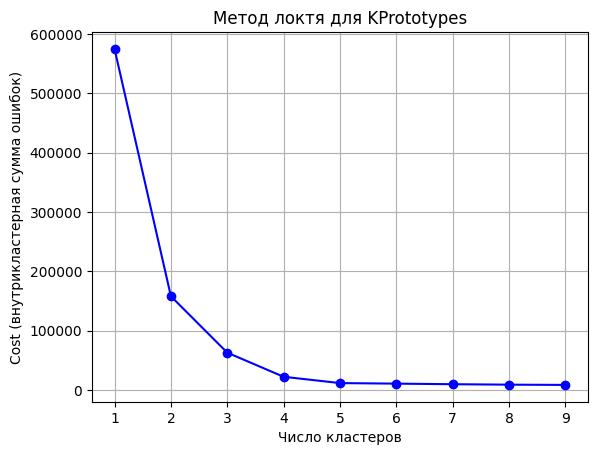

In [ ]:
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt

X = df_with_effort.drop('PlacedOrNot', axis=1)
X_matrix = X.to_numpy()


costs = []
K = range(1, 10)  # число кластеров от 1 до 10
categorical_cols = [2]  # номер категориального столбца

for k in K:
    print(k)
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=0, random_state=42)
    kproto.fit_predict(X_matrix, categorical=categorical_cols)
    costs.append(kproto.cost_)

plt.plot(K, costs, 'bo-')
plt.xlabel('Число кластеров')
plt.ylabel('Cost (внутрикластерная сумма ошибок)')
plt.title('Метод локтя для KPrototypes')
plt.grid()
plt.show()

### k=5 оптимально

In [ ]:
kproto = KPrototypes(n_clusters=5, init='Cao', verbose=0, random_state=42)
clusters = kproto.fit_predict(X_matrix, categorical=categorical_cols)
df_with_effort['Cluster'] = clusters

## 3. Считаем:
### 1) успешность стратегии (вероятность попасть на работу)
### 2) среднее усилие реализации пути
### 3) нестабильность пути (размах, дисперсия)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных

# Создаём подписи для кластеров с успешностью
success_rates = df_with_effort.groupby("Cluster")["PlacedOrNot"].mean().round(2)
cluster_labels = {i: f"{i}_succ:{s:.2f}" for i, s in success_rates.items()}
df_with_effort["ClusterLabel"] = df_with_effort["Cluster"].map(cluster_labels)

## 3. Визуализация распределения. Анализ стратегий. Выбор оптимального пути: минимум усилий, максимум результата (к слову минимума усилия нет, работать всё равно придётся)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

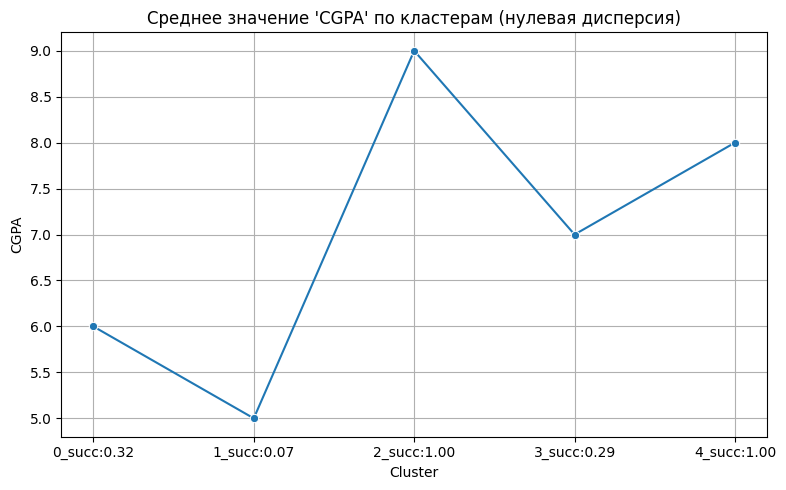

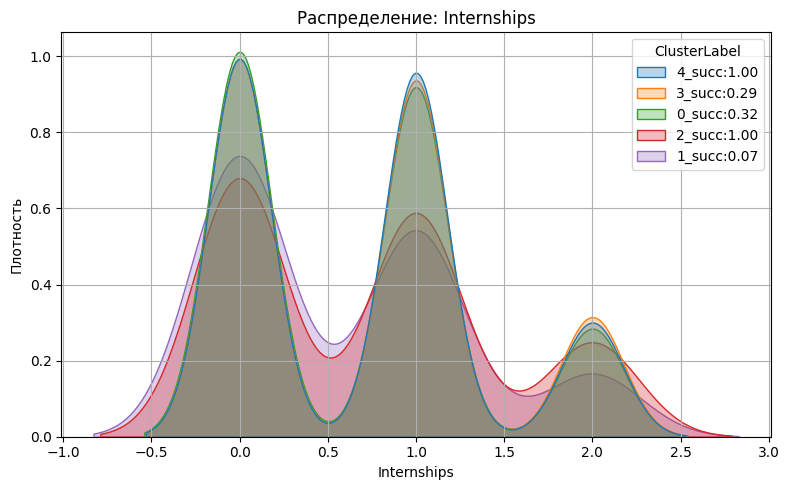

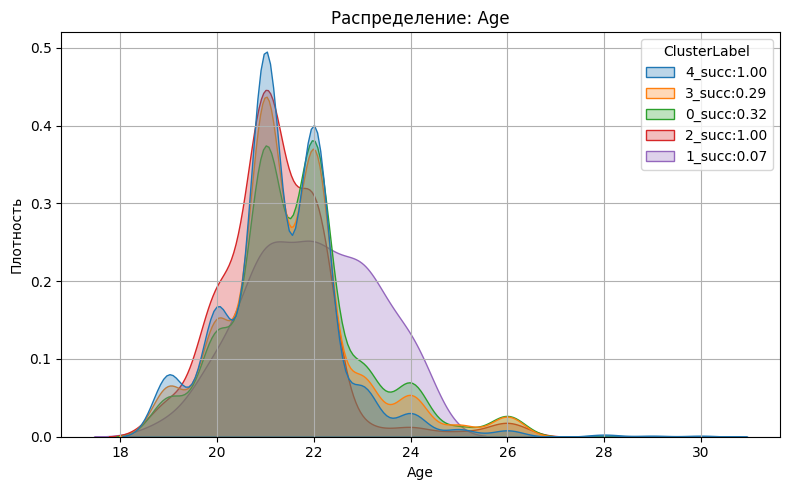

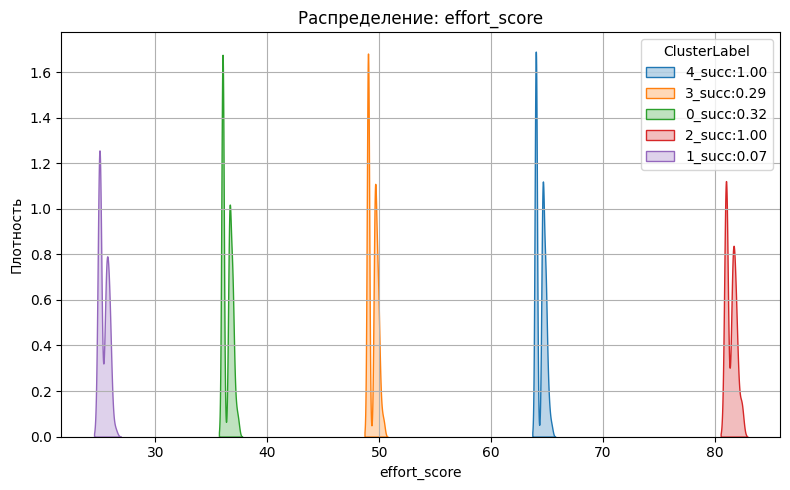

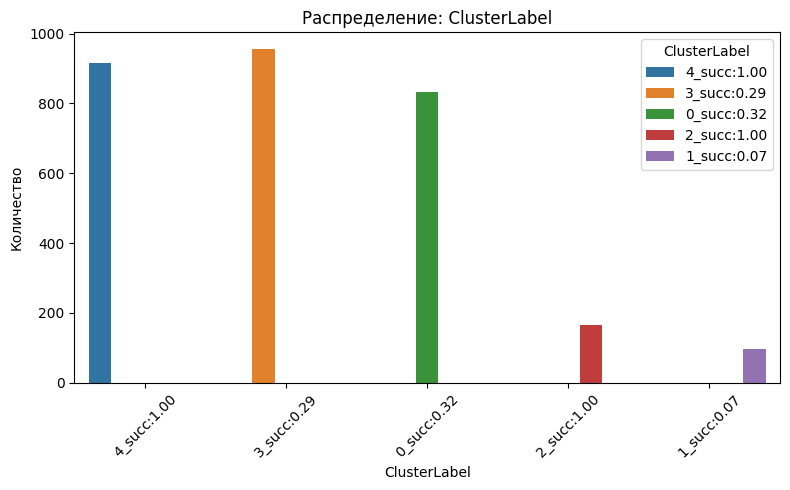

In [ ]:
X = df_with_effort.drop('PlacedOrNot', axis=1)
# Численные фичи — линии
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()


import matplotlib.pyplot as plt
import seaborn as sns


for col in numerical_cols:
    plt.figure(figsize=(8, 5))

        # Проверяем дисперсию для каждого кластера
    zero_variance = df_with_effort.groupby("ClusterLabel")[col].nunique().le(1).all()

    if zero_variance:
            # Строим график средних значений, если все значения константны по кластерам
        means = df_with_effort.groupby("ClusterLabel")[col].mean()
        sns.lineplot(x=means.index.astype(str), y=means.values, marker='o')
        plt.ylabel(col)
        plt.xlabel("Cluster")
        plt.title(f"Среднее значение '{col}' по кластерам (нулевая дисперсия)")
    else:
        try:
            sns.kdeplot(
                    data=df_with_effort,
                    x=col,
                    hue="ClusterLabel",
                    common_norm=False,
                    fill=True,
                    alpha=0.3
            )
            plt.xlabel(col)
            plt.ylabel("Плотность")
            plt.title(f"Распределение: {col}")
        except Exception as e:
            print(f"[⚠️] Ошибка при построении графика для '{col}': {e}")
            continue

    plt.tight_layout()
    plt.grid(True)
    plt.show()

# Категориальные фичи — столбцы
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
for col in categorical_cols:
    if col != "ClusterLabel": continue
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df_with_effort, x=col, hue="ClusterLabel")
    plt.title(f"Распределение: {col}")
    plt.xlabel(col)
    plt.ylabel("Количество")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
# Группировка по кластерам и агрегация
cluster_summary = df_with_effort.groupby('Cluster').agg(
    SuccessRate=('PlacedOrNot', 'mean'),
    AvgDifficulty=('effort_score', 'mean'),
    DifficultyStd=('effort_score', 'std'),
    DifficultyMin=('effort_score', 'min'),
    DifficultyMax=('effort_score', 'max'),
    Count=('PlacedOrNot', 'count')
).reset_index()

# Добавляем столбец "Эффективность"
cluster_summary['Efficiency'] = round(cluster_summary['SuccessRate'] / cluster_summary['AvgDifficulty'] * 100, 2)

print(cluster_summary)


   Cluster  SuccessRate  AvgDifficulty  DifficultyStd  DifficultyMin  \
0        0     0.323741      36.422983       0.417234           36.0   
1        1     0.072917      25.370882       0.403874           25.0   
2        2     1.000000      81.443557       0.443036           81.0   
3        3     0.294979      49.431949       0.413652           49.0   
4        4     1.000000      64.426497       0.407294           64.0   

   DifficultyMax  Count  Efficiency  
0      37.428196    834        0.89  
1      26.428196     96        0.29  
2      82.428196    165        1.23  
3      50.428196    956        0.60  
4      65.428196    915        1.55  


# 🎓 Разбор стратегий трудоустройства студентов на основе кластеров

> *Исследование показывает, как различные сочетания успеваемости, стажировок и направления подготовки формируют стратегии выхода на рынок труда. Разделено на 5 кластеров — каждый со своей логикой и шансами.*

---

## 🟩 Кластер 0 — **«Максимум усилий, максимум результат», коэфицент эффеткивности 1.23**

| Показатель         | Значение    |
|--------------------|-------------|
| 🎯 Успешность       | **100%**     |
| 📈 Сложность        | 81.5        |
| 🎓 GPA             | ~9.0        |
| 🛠️ Стажировки      | 2–3         |
| ⚙️ Уровень усилий   | Очень высокий |

**Описание:**  
Путь отличников и самых трудолюбивых. Учёба + стажировки = максимальный шанс.

**✅ Подходит тем, кто:**
- Стремится попасть в топ-компании.
- Готов временно пожертвовать балансом.
- Умеет работать системно.

---

## 🟦 Кластер 3 — **«Умный баланс» _(рекомендуемая стратегия)_, коэфицент эффеткивности 1.23**

| Показатель         | Значение    |
|--------------------|-------------|
| 🎯 Успешность       | **100%**     |
| 📈 Сложность        | 64.4        |
| 🎓 GPA             | ~8.0        |
| 🛠️ Стажировки      | 1           |
| ⚙️ Уровень усилий   | Умеренный   |

**Описание:**  
Это сбалансированная стратегия: хорошая успеваемость, хотя бы одна стажировка. Оптимальна для большинства студентов.

**✅ Подходит тем, кто:**
- Хочет уверенный выход на рынок.
- Не готов к жёсткому режиму, но хочет результата.
- Готов уделить немного времени практике.

---

## 🟧 Кластер 1 — **«Не туда, не сюда», коэфицент эффеткивности 0.60**

| Показатель         | Значение    |
|--------------------|-------------|
| 🎯 Успешность       | ~29%        |
| 📈 Сложность        | 49.4        |
| 🎓 GPA             | ~7.0        |
| 🛠️ Стажировки      | редко       |
| ⚙️ Уровень усилий   | средний     |

**Описание:**  
Учёба без особых усилий. Крепкий "среднячок".

**⚠️ Подходит тем, кто:**
- Пока не определился с целями.
- Готов улучшать ситуацию вне учёбы (проекты, курсы).
- Понимает, что шансы нестабильны.

---

## 🟨 Кластер 2 — **«Плыву по течению», коэфицент эффеткивности 0.89**

| Показатель         | Значение    |
|--------------------|-------------|
| 🎯 Успешность       | ~32%        |
| 📈 Сложность        | 36.4        |
| 🎓 GPA             | ~6.0        |
| 🛠️ Стажировки      | почти нет   |
| ⚙️ Уровень усилий   | низкий      |

**Описание:**  
Минимальные усилия → минимальный шанс. Больше похоже на выживание. С другой стороны, на порядок легче чем стратегия "Не туда, не сюда" и не уступает в вероятности. Если бы хотел насладиться студенческой жизнью и не потерять шансы на карьеру - выбрал бы её.

**⚠️ Подходит тем, кто:**
- Не готов сейчас «вкладываться», но думает наверстать.
- Может быть, меняет профессию.
- Пока учится «на автопилоте».

---

## 🟥 Кластер 4 — **«Ничего не делаю», коэфицент эффеткивности 0.29**

| Показатель         | Значение    |
|--------------------|-------------|
| 🎯 Успешность       | **7%**       |
| 📈 Сложность        | 25.4        |
| 🎓 GPA             | ~5.0        |
| 🛠️ Стажировки      | нет         |
| ⚙️ Уровень усилий   | минимальный |

**Описание:**  
Это не стратегия. Это путь к провалу.

**🚫 Подходит тем, кто:**
- Не собирается работать по специальности.
- Полностью потерял интерес к учёбе.
- Не рассчитывает на карьеру после вуза.

---

## 📊 Сравнительная таблица по стратегиям

| Стратегия                         | Успешность | Уровень усилий | Эффективность | Вывод |
|----------------------------------|------------|-----------|----------------|-------|
| 🟩 Кластер 0 — Максимум           | ✅ 100%     | 🔴 Высокий | 🟡 Хорошая      | Только для мотивированных |
| 🟦 Кластер 3 — Умный баланс       | ✅ 100%     | 🟡 Выше средний | 🟢 Высокая    | **Рекомендуем большинству** |
| 🟧 Кластер 1 — Не туда, не сюда       | ⚠️ ~29%     | 🟡 Средний | 🔴 Низкая     | Много усилий, но мало толку |
| 🟨 Кластер 2 — "Плыву по течению"            | ⚠️ ~32%     | 🟢 Низкий  | 🟡 Средняя        | Риск провала без доп. усилий |
| 🟥 Кластер 4 — Без стратегии      | ❌ 7%       | 🟢 Очень низ.| ⚫️ Очень низкий | Практически бесперспективно |

---

## ✅ Общий вывод

Если ты хочешь **выйти на рынок уверенно**, но **не перегореть** — **кластер 3 (умный баланс)** подходит лучше всего.  
Никакой магии — просто **вовремя начать**, **не запускать успеваемость**, и **сделать хотя бы 1 стажировку**.
Это и есть стратегия большинства тех, кто потом с гордостью пишет «принят в компанию мечты».



### **Примечание:** Данный датасет ориентирован преимущественно на образовательные системы стран Европы и США. Тем не менее, при сопоставлении с ведущими университетами России (топ-10 или топ-15), многие выводы и рекомендации сохраняют свою актуальность.
